## Manipulating Images

In [1]:
import imfusion
import numpy as np
from copy import deepcopy

from imfusion_sdk.demo_utils import mpr_plot, unzip_folder

unzipped_folder = unzip_folder('data/pet-ct-rtstruct.zip')

Public beta build of ImFusion Python SDK. Not for commercial use.


### Orientation and size of the image in the physical world
- Pixel Space: the grid where the voxels are indexed (`i` in `[0, Width]`, `j` in `[0, Heigth]`, `k` in `[0, Slices]`).
- Image Space: Voxel grid in metric units (mm), with center of the image defined as `O = (x, y, z) = (0, 0, 0)`.
The size of a voxel is defined by the `spacing`. Image coordinates take values `x` in `[-SizeX / 2, SizeX / 2]`, `y` in `[-SizeY / 2, SizeY / 2]`, `x` in `[-SizeZ / 2, SizeZ / 2]`.
- World Space: Every SharedImage contains a `matrix` which describes the orientation of the voxel array in the physical world. The `matrix` specifies the transformation from the image space to the physical world.

![Coordinate Systems](images/CoordinateSystems.png)

In [2]:
pet_sis, *_ = imfusion.load('data/pet-ct-rtstruct/pet')
pet_image = pet_sis[0]

np.set_printoptions(suppress=True)

print('Image matrix:\n', pet_image.matrix) # matrix from world
print('Image spacing:', pet_image.descriptor.spacing)
print('Image dimensions:', pet_image.descriptor.dimensions)
print('Image extent:', pet_image.descriptor.extent)
print('Image coordinate of Voxel (0, 0, 0)', pet_image.descriptor.pixel_to_image([0, 0, 0]))
print('Voxel coordinate of Image Center (0., 0., 0.)', pet_image.descriptor.image_to_pixel([0., 0., 0.]))

# get world position of Voxel (0, 0, 0):
print(f'World coordinate (aka Position) of Voxel (0, 0, 0): {pet_image.descriptor_world.pixel_to_world([0, 0, 0])}')
print(f'World coordinate of Image Center (0., 0., 0.): {np.matmul(pet_image.descriptor_world.matrix_to_world, np.array([0., 0., 0., 1.]))}')

Image matrix:
 [[  1.          -0.           0.           0.00001776]
 [  0.           1.          -0.           0.00001776]
 [ -0.           0.           1.         414.51000977]
 [  0.          -0.          -0.           1.        ]]
Image spacing: [3.64583325 3.64583325 3.27000009]
Image dimensions: [192 192 227]
Image extent: [699.99998474 699.99998474 742.29001962]
Image coordinate of Voxel (0, 0, 0) [-348.17707574 -348.17707574 -369.51000977]
Voxel coordinate of Image Center (0., 0., 0.) [ 95.5  95.5 113. ]
World coordinate (aka Position) of Voxel (0, 0, 0): [-348.17709351 -348.17709351 -784.02001953]
World coordinate of Image Center (0., 0., 0.): [  -0.00001776   -0.00001776 -414.51000977    1.        ]
[DICOM] Detected different rescale values per frame, rescale will be burned into pixel data!
[DICOM] Detected frame with shift/scale pair which exceeds the value range. Casting all frames to Float.


Algorithms of the ImFusion SDK take the orientation and spacing information into account.

If we resample the image to a spacing of 2 mm in each dimension, the information in the SharedImage is also updated automatically:

In [3]:
print("before:\t", pet_sis[0].descriptor)

resample_algo = imfusion.ImageResamplingAlgorithm(pet_sis)
# Create new image or resample image in ctor in places
resample_algo.create_new_image = True
# Resampling mode, can be a spacing, a percentage, a dimension, a binning..
resample_algo.resampling_mode = imfusion.ImageResamplingAlgorithm.ResamplingMode.TARGET_SPACING
# Reduction can be Lookup, Average, Min, Max
resample_algo.reduction_mode = imfusion.ReductionMode.AVERAGE
# Interpolation can be nearest, linear or bicubic
resample_algo.interpolation_mode = imfusion.InterpolationMode.LINEAR
resample_algo.target_spacing = [2., 2., 2.] # mm
resample_algo.compute()
(resampled_pet,) = resample_algo.output()

imfusion.save([resampled_pet], '../data/resampled_pet.imf')

print("after:\t", resampled_pet[0].descriptor)

before:	 imfusion.ImageDescriptor(dimensions: [w:192, h:192, s:227, c:1] | spacing:[3.64583, 3.64583, 3.27] | isMetric:true | type:FLOAT | memory: 31.92 MB)
after:	 imfusion.ImageDescriptor(dimensions: [w:350, h:350, s:371, c:1] | spacing:[2, 2, 2] | isMetric:true | type:FLOAT | memory: 173.4 MB)


We can also resample based on geometric descriptor of another image.

Since the SharedImages contain the orientation and spacing information, we can easily resample using a reference image.

To leverage that, the ResampleImageAlgorithm can be used with two input: the image to resample and a reference image.

In [4]:
(ct_sis,) = imfusion.load('data/pet-ct-rtstruct/ct.imf')

print(f'original CT: {ct_sis[0].descriptor}\n')

resample_algo = imfusion.ImageResamplingAlgorithm(ct_sis, resampled_pet)
resample_algo.create_new_image = True
resample_algo.compute()
(resampled_ct,) = resample_algo.output()
imfusion.save([resampled_ct], '../data/resampled_ct.imf')


print(f'CT: {resampled_ct[0].descriptor}')
print(f'PET: {resampled_pet[0].descriptor}')

original CT: imfusion.ImageDescriptor(dimensions: [w:167, h:167, s:247, c:1] | spacing:[3, 3, 3] | isMetric:true | shift:2048 | type:USHORT | memory: 13.14 MB)

CT: imfusion.ImageDescriptor(dimensions: [w:350, h:350, s:371, c:1] | spacing:[2, 2, 2] | isMetric:true | shift:2048 | type:USHORT | memory: 86.68 MB)
PET: imfusion.ImageDescriptor(dimensions: [w:350, h:350, s:371, c:1] | spacing:[2, 2, 2] | isMetric:true | type:FLOAT | memory: 173.4 MB)


#### Advanced use of ImageResamplingAlgorithm 

Since we actually need just geometric information, it is possible to use the image resampling algorithm to create a well defined crop/pad of the image by solely specifying a geometric descriptor

imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(FLOAT width: 160 height: 160 slices: 160 spacing: 1.5 mm)])
Original:


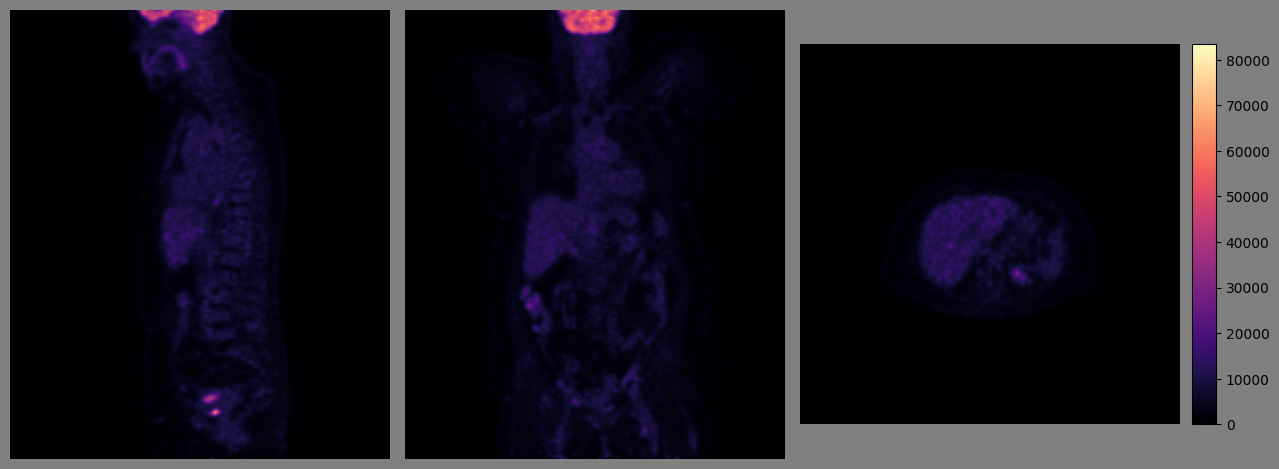

Cropped:


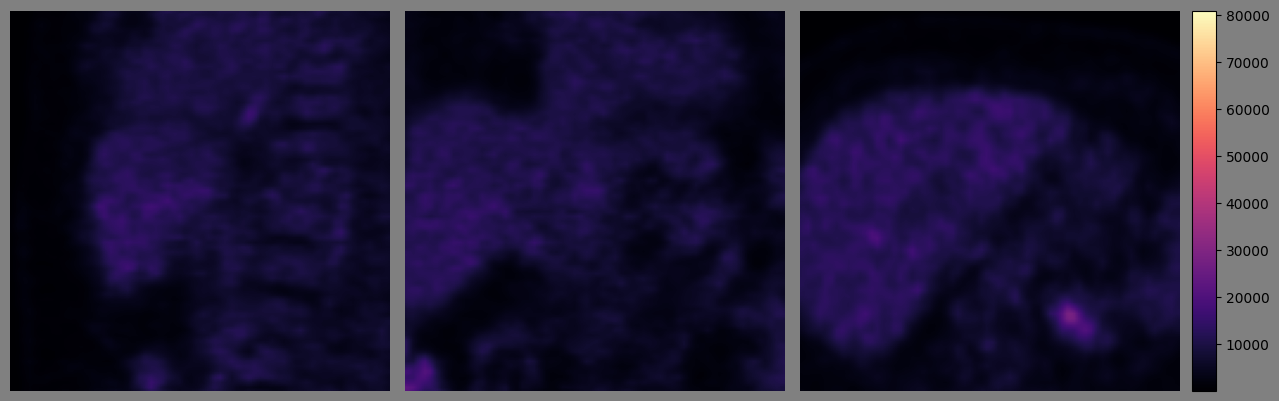

In [5]:
new_descriptor_world = pet_sis[0].descriptor_world
# We want to crop/pad at the current center of the image, thus we leave the 
# translation part of the affine matrix untouched, while setting to Identity the 
# rotation part
original_matrix = deepcopy(new_descriptor_world.matrix_to_world)
original_matrix[:3, :3] = np.eye(3)
new_descriptor_world.matrix_to_world = original_matrix

# Adjust the dimensions and the pixel spacing.
# The resulting image will have an isotropic extent of 12.8 cm
new_descriptor_world.descriptor.spacing = [1.5, 1.5, 1.5]
new_descriptor_world.descriptor.dimensions = [160, 160, 160]

resample = imfusion.ImageResamplingAlgorithm(pet_sis, [new_descriptor_world])
resample.create_new_image = True
resample.resampling_mode = imfusion.ImageResamplingAlgorithm.ResamplingMode.TARGET_PERCENT
resample.reduction_mode = imfusion.ReductionMode.AVERAGE
resample.interpolation_mode = imfusion.InterpolationMode.LINEAR
resample.compute()

cropped_pet = resample.output()[0]

print(cropped_pet)

imfusion.save([cropped_pet], '../data/cropped_pet.imf')

print("Original:")
mpr_plot(pet_sis[0])
print("Cropped:")
mpr_plot(cropped_pet[0])
None